# CV - Transfer Learning & Fine Tuning
## Framework: Tensorflow | Dataset: 10 Food Items

<img src="https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/04-transfer-learning-feature-extraction.png" alt="Alt Text" width="900"/>

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

import zipfile
import os

2025-11-03 19:16:09.756445: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Downloading the dataset

In [ ]:
# !wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

In [ ]:
# zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip", "r")
# zip_ref.extractall()
# zip_ref.close()

In [2]:
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent

## Creating data loaders

In [3]:
PATH = '10_food_classes_10_percent'

train_dir = os.path.join(PATH, 'train')
test_dir = os.path.join(PATH, 'test')

BATCH_SIZE = 32
IMG_SIZE = (224, 224)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

validation_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 750 files belonging to 10 classes.


I0000 00:00:1762180311.569305   13025 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7535 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:01:00.0, compute capability: 8.6


Found 2500 files belonging to 10 classes.


In [4]:
for images, labels in train_dataset.take(1):
    print(f"Images shape: {images.shape}")
    print(f"Labels shape: {labels.shape}")
    print(f"Labels: {labels.numpy()}")

Images shape: (32, 224, 224, 3)
Labels shape: (32,)
Labels: [6 9 7 8 8 1 9 1 1 3 8 3 6 0 1 2 2 5 9 2 3 7 4 2 4 2 1 9 4 2 2 7]


2025-11-03 19:32:09.293542: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [5]:
class_names = train_dataset.class_names
print(class_names)

['chicken_curry', 'chicken_wings', 'fried_rice', 'grilled_salmon', 'hamburger', 'ice_cream', 'pizza', 'ramen', 'steak', 'sushi']


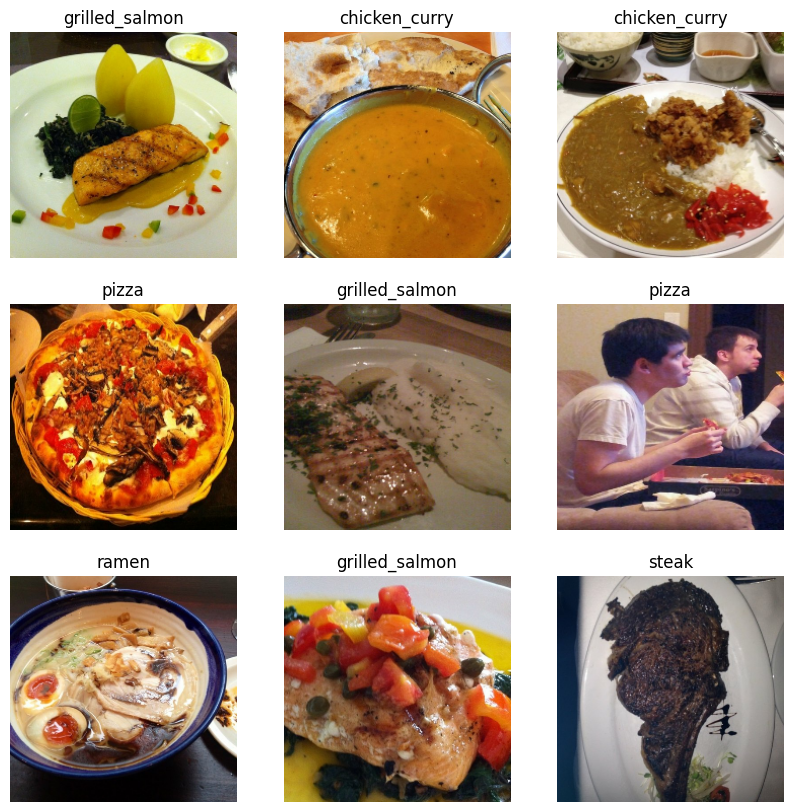

In [9]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

# Creating test and validation sets

In [10]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(4* val_batches // 5)
validation_dataset = validation_dataset.skip(4* val_batches // 5)

In [11]:
print('Number of train batches: %d' % tf.data.experimental.cardinality(train_dataset))
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of train batches: 24
Number of validation batches: 16
Number of test batches: 63


## Prefecting Data Pipeline

<img src="https://d2908q01vomqb2.cloudfront.net/f1f836cb4ea6efb2a0b1b99f41ad8b103eff4b59/2022/08/04/ML-9755-fig-4.png" alt="Alt Text" width="900"/>


In [12]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

## Loading the Pretrained Model

In [13]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [14]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [15]:
base_model.trainable = False

In [16]:
base_model.summary()

Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

## Adding custom top to the base model

In [17]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

2025-11-03 19:53:33.123011: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91301


(32, 7, 7, 1280)


In [18]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [19]:
prediction_layer = tf.keras.layers.Dense(10, activation='softmax')

prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 10)


In [20]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
])

In [21]:
dropout_layer = tf.keras.layers.Dropout(0.2)

In [22]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = dropout_layer(x)
outputs = prediction_layer(x)


model = tf.keras.Model(inputs, outputs)

In [23]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,270,794 (8.66 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [24]:
len(model.trainable_variables)

2

## Train the model

In [25]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=["accuracy"])

In [26]:
loss0, accuracy0 = model.evaluate(validation_dataset)

16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.0640 - loss: 2.8881


In [27]:
# from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                                 factor=0.5, 
                                                 patience=3, 
                                                 min_lr=1e-6,
                                                 verbose=1)
checkpoint = tf.keras.callbacks.ModelCheckpoint('best_tuned_model.keras', 
                                                monitor='val_loss', 
                                                save_best_only=True, 
                                                verbose=1)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                              patience=10, 
                                              restore_best_weights=True, 
                                              verbose=1)

In [28]:
initial_epochs = 100

history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset,
                    callbacks=[reduce_lr, checkpoint, early_stop])

Epoch 1/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.0860 - loss: 2.9957
Epoch 1: val_loss improved from None to 2.56580, saving model to best_tuned_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 119ms/step - accuracy: 0.0907 - loss: 2.9189 - val_accuracy: 0.0971 - val_loss: 2.5658 - learning_rate: 1.0000e-04
Epoch 2/100
23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.1082 - loss: 2.7054
Epoch 2: val_loss improved from 2.56580 to 2.42673, saving model to best_tuned_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 0.1293 - loss: 2.6115 - val_accuracy: 0.1281 - val_loss: 2.4267 - learning_rate: 1.0000e-04
Epoch 3/100
23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.1652 - loss: 2.4722
Epoch 3: val_loss improved from 2.42673 to 2.30247, saving model to best_tuned_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 0.1573 - loss: 2.4408 - val_accuracy: 0.1653 - val_loss: 2.3025 - learning_rate: 1.0000e-04
Epoch 4/100
23/24 ━━━━━━━━━━━━━━━━━━━

In [29]:
loss1, accuracy1 = model.evaluate(test_dataset)
print('Test loss :', loss1)
print('Test accuracy :', accuracy1)

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.7872 - loss: 0.7157
Test loss : 0.7156972289085388
Test accuracy : 0.7872023582458496


In [31]:
history_df = pd.DataFrame(history.history)

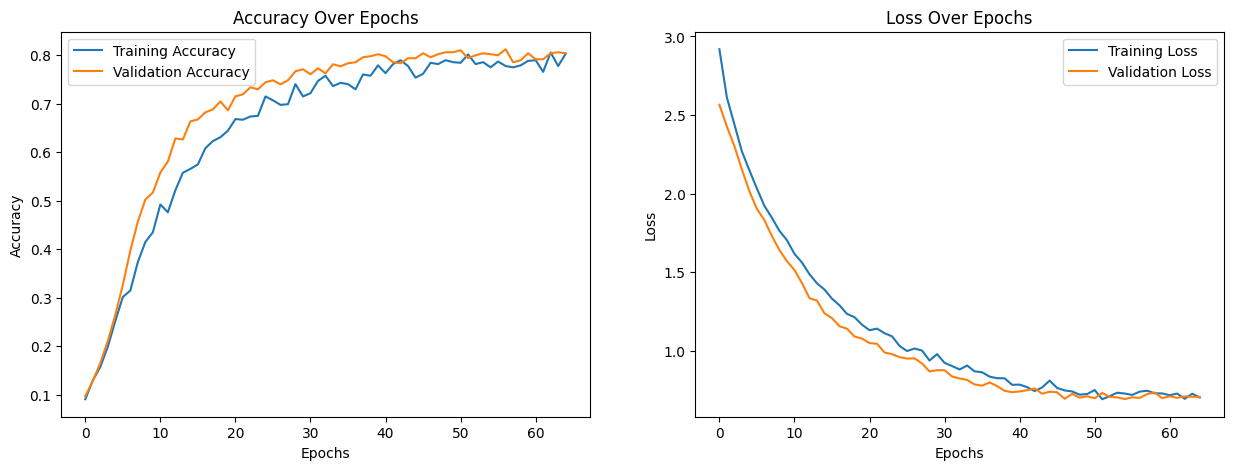

In [32]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(history_df['accuracy'], label='Training Accuracy')
plt.plot(history_df['val_accuracy'], label='Validation Accuracy')
plt.title("Accuracy Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_df['loss'], label='Training Loss')
plt.plot(history_df['val_loss'], label='Validation Loss')
plt.title("Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [33]:
from sklearn.metrics import confusion_matrix

y_true = []
y_pred = []
for images, labels in test_dataset:
    preds = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

cm = confusion_matrix(y_true, y_pred)

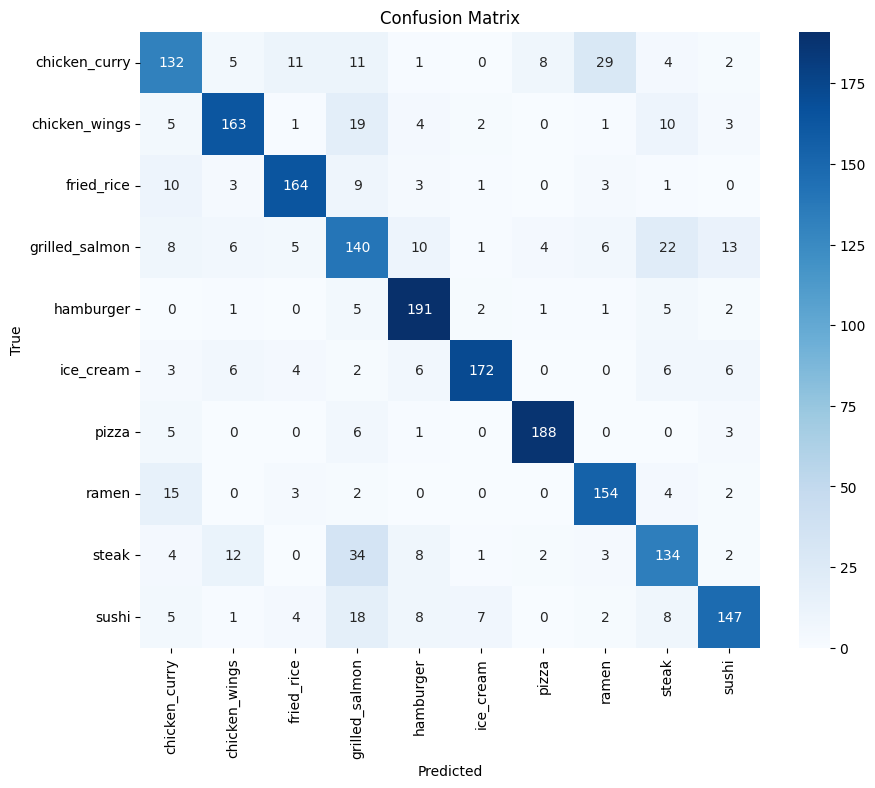

In [34]:
# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Fine Tuning the Model

<img src="https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/04-different-kinds-of-transfer-learning.png" alt="Alt Text" width="900"/>

In [35]:
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  154


In [67]:
base_model.trainable = True

In [68]:
fine_tune_at = 145

for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

In [69]:
len(model.trainable_variables)

11

In [70]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10),
              metrics=["accuracy"])

In [71]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,270,794 (8.66 MB)

 Trainable params: 743,370 (2.84 MB)

 Non-trainable params: 1,527,424 (5.83 MB)

In [72]:
fine_tune_epochs = 100
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=len(history.epoch),
                         validation_data=validation_dataset,
                         callbacks=[reduce_lr, checkpoint, early_stop])

Epoch 66/200
23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8382 - loss: 0.5481
Epoch 66: val_loss did not improve from 0.56215
24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 155ms/step - accuracy: 0.8413 - loss: 0.5565 - val_accuracy: 0.8037 - val_loss: 0.5851 - learning_rate: 1.0000e-05
Epoch 67/200
23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8678 - loss: 0.5032
Epoch 67: val_loss did not improve from 0.56215
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - accuracy: 0.8667 - loss: 0.4974 - val_accuracy: 0.7913 - val_loss: 0.5927 - learning_rate: 1.0000e-05
Epoch 68/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8529 - loss: 0.5278
Epoch 68: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.

Epoch 68: val_loss did not improve from 0.56215
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - accuracy: 0.8533 - loss: 0.5223 - val_accuracy: 0.8120 - val_loss: 0.5802 - learning_rate: 1.0000e-05
Epoch 69/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.8773 - loss: 0.

In [73]:
loss2, accuracy2 = model.evaluate(test_dataset)
print('Test loss :', loss2)
print('Test accuracy :', accuracy2)

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.8145 - loss: 0.5670
Test loss : 0.567021906375885
Test accuracy : 0.8144841194152832


In [74]:
history_fine_df = pd.DataFrame(history_fine.history)
history_fine_df.index += len(history_df)

In [75]:
history_full_df = pd.concat([history_df, history_fine_df])

In [76]:
finetune_start_epoch = len(history_df)

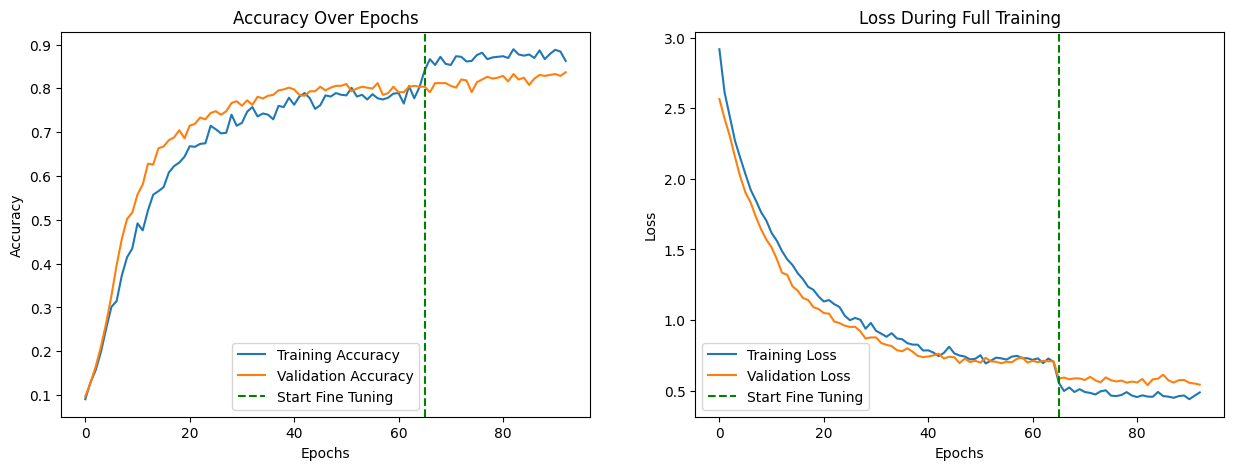

In [77]:
plt.figure(figsize=(15, 5))

# --- Accuracy Plot ---
plt.subplot(1, 2, 1)
plt.plot(history_full_df['accuracy'], label='Training Accuracy')
plt.plot(history_full_df['val_accuracy'], label='Validation Accuracy')
plt.axvline(x=finetune_start_epoch, linestyle='--', color='green', label='Start Fine Tuning')
plt.title("Accuracy Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# --- Loss Plot ---
plt.subplot(1, 2, 2)
plt.plot(history_full_df['loss'], label='Training Loss')
plt.plot(history_full_df['val_loss'], label='Validation Loss')
plt.axvline(x=finetune_start_epoch, linestyle='--', color='green', label='Start Fine Tuning')
plt.title("Loss During Full Training")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()


In [78]:
y_true = []
y_pred = []
for images, labels in test_dataset:
    preds = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

cm = confusion_matrix(y_true, y_pred)

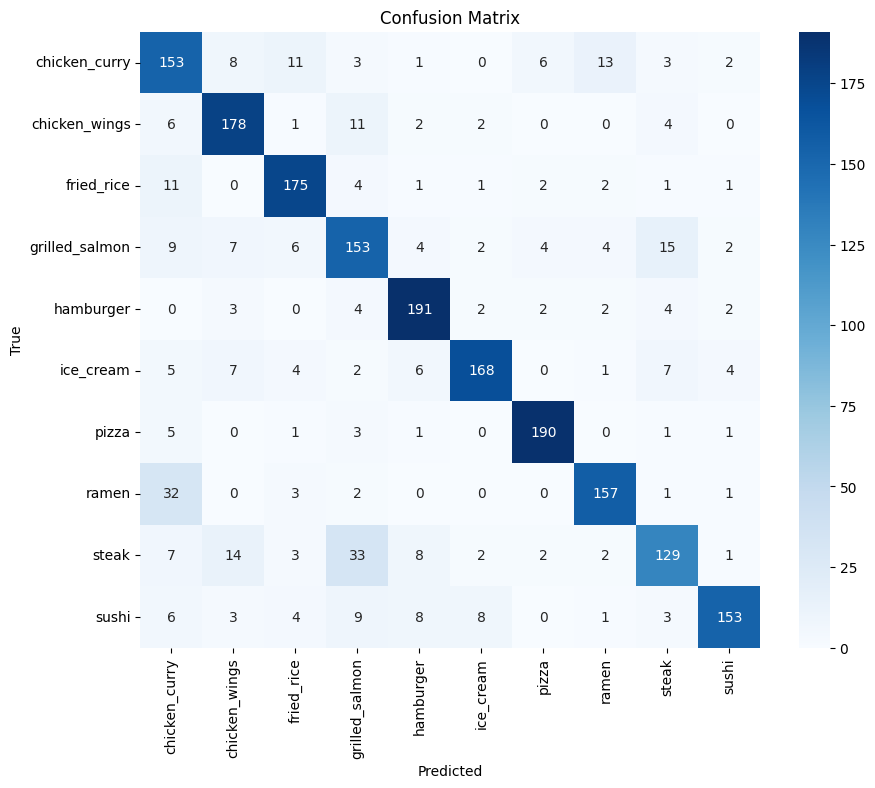

In [79]:
# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [80]:
# Print comparison side by side
print("\nComparison:")
print(f"{'Metric':<15}{'Base Model':<15}{'Fine Tuning'}")
print(f"{'-'*40}")
print(f"{'Loss':<15}{loss1:<15.4f}{loss2:.4f}")
print(f"{'Accuracy':<15}{accuracy1:<15.4f}{accuracy2:.4f}")


Comparison:
Metric         Base Model     Fine Tuning
----------------------------------------
Loss           0.7157         0.5670
Accuracy       0.7872         0.8145


Predictions:
 [2 8 1 4 5 0 7 1 2 7 1 3 0 6 3 3 1 0 8 4 7 2 3 7 5 6 2 6 9 3 3 0]
Labels:
 [2 8 1 9 5 0 7 8 2 7 1 3 0 6 0 3 5 7 2 4 0 2 9 7 5 6 2 6 9 1 3 0]


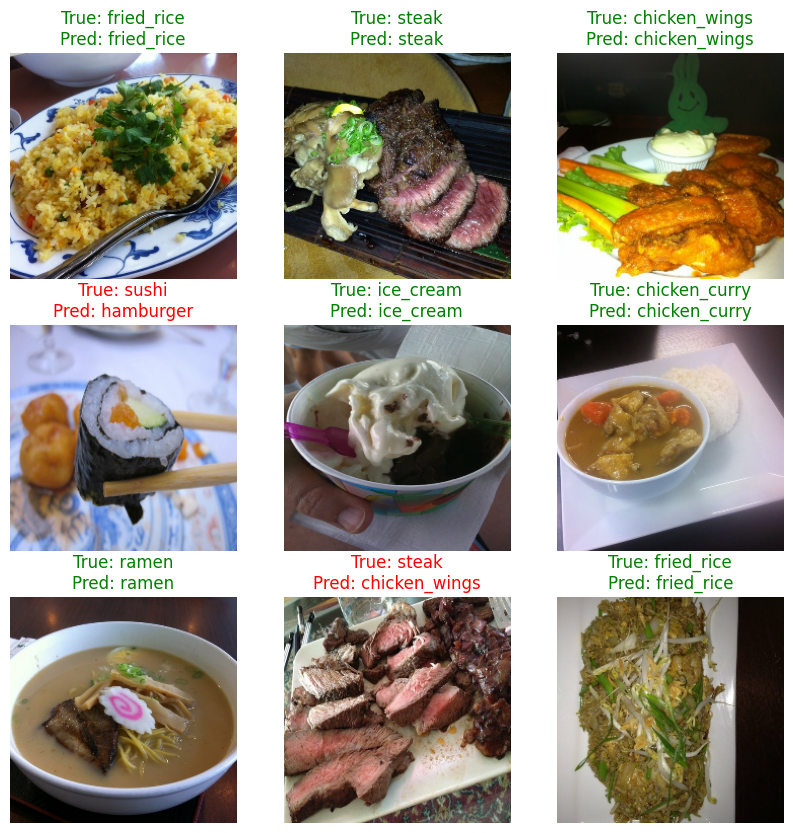

In [84]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)
predicted_classes = np.argmax(predictions, axis=1)

print('Predictions:\n', predicted_classes)
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  true_label = class_names[label_batch[i]]
  predicted_label = class_names[predicted_classes[i]]
  plt.title(f"True: {true_label}\nPred: {predicted_label}", color="green" if true_label == predicted_label else "red")
  plt.axis("off")

In [ ]:
keras 